In [67]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(".\properatti.csv", index_col=0)
data.shape

(121220, 25)

In [3]:
# Definimos dos grupos de columas para poder trabajar con ellas de forma mas sencilla
places = ['place_name','place_with_parent_names', 'country_name','state_name']
geolocation = ['geonames_id', 'lat-lon','lat','lon']

# Creamos un nuevo dataframe con las columnas que me interesan
geo_location_data = data[ geolocation].copy()
geo_location_data.head()

,geonames_id,lat-lon,lat,lon
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447


In [4]:
# Vemos que hay valores nulos en las columnas que nos interesan
geo_location_data.isnull().sum()


geonames_id    18717
lat-lon        51550
lat            51550
lon            51550
dtype: int64

### Corroborar si lat-lon coincide con las columnas lat y lon

In [5]:
# Corroboremos que los valores nulos en lat-lon son los mismos que en lat y lon
geo_location_data[geo_location_data['lat-lon'].isnull()]['lat'].isnull().sum() == geo_location_data[geo_location_data['lat-lon'].isnull()]['lon'].isnull().sum()


True

In [6]:
# Dropeamos los valores nulos de lat-lon
geo_location_data.dropna(subset=['lat-lon'], inplace=True)
geo_location_data.isnull().sum()

geonames_id    10532
lat-lon            0
lat                0
lon                0
dtype: int64

In [7]:
# Convertimos la columna lat-lon en dos columnas nuevas
geo_location_data['lat_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[0])
geo_location_data['lon_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[1])
geo_location_data.head()


,geonames_id,lat-lon,lat,lon,lat_alt,lon_alt
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,-34.6618237,-58.5088387
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,-34.9038831,-57.9643295
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,-34.6522615,-58.5229825
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,-34.6477969,-58.5164244
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,-38.0026256,-57.5494468


In [8]:
# Vemos los tipos de datos
geo_location_data.dtypes

geonames_id    float64
lat-lon         object
lat            float64
lon            float64
lat_alt         object
lon_alt         object
dtype: object

In [9]:
# convertimos las nuevas columnas a float
geo_location_data['lat_alt'] = geo_location_data['lat_alt'].astype(float)
geo_location_data['lon_alt'] = geo_location_data['lon_alt'].astype(float)
geo_location_data.dtypes

geonames_id    float64
lat-lon         object
lat            float64
lon            float64
lat_alt        float64
lon_alt        float64
dtype: object

In [18]:
# Comprobamos que los valores de las nuevas columnas son iguales a los de las columnas originales
print("Diferencia entre lat:",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum())
print("Diferencia entre lon:",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum())
# En proporción
print("Diferencia en proporción de lat",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum()/ geo_location_data.shape[0])
print("Diferencia en proporción de lon",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum()/ geo_location_data.shape[0])


Diferencia entre lat: 11507
Diferencia entre lon: 14658
Diferencia en proporción de lat 0.16516434620353093
Diferencia en proporción de lon 0.21039184728003446


Hay diferencias en 21% los casos. Veamos si es una diferencia significativa

Revisamos el margen de diferencia redondeando progresivamente.

In [56]:
from decimal import Decimal

In [58]:
Decimal(geo_location_data['lon'][0]).as_tuple().exponent

-46

In [60]:
# Reviso la cantidad de decimales que tienen los valores de lat y lon
geo_location_data['lat'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    33560
-46    16130
-45     7979
-44     4494
-48     3399
-43     2077
-42     1028
-41      564
-40      164
-39      155
-38       55
-37       32
-36       18
-35        5
-7         4
-8         2
 0         2
-34        1
-4         1
Name: lat, dtype: int64

In [61]:
geo_location_data['lon'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    31972
-46    18963
-45     9048
-44     5085
-43     2337
-42     1188
-41      561
-40      213
-39      190
-38       52
-37       28
-36       20
-34        4
-35        3
 0         2
-8         1
-2         1
-32        1
-4         1
Name: lon, dtype: int64

In [73]:
# Vamos redondeando progresivamente los valores de lat y lon
lat_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lat_alt'].round(i) != geo_location_data['lat'].round(i)).sum()/ geo_location_data.shape[0]
    lat_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en latitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)
   
print("////////////////////////////////////")   

lon_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lon_alt'].round(i) != geo_location_data['lon'].round(i)).sum()/ geo_location_data.shape[0]
    lon_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en longitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)




Margen de diferencia de 14 decimales en latitud: 0.009157456581024832
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0
Margen de diferencia de 10 decimales en latitud: 0.0
Margen de diferencia de 9 decimales en latitud: 0.0006171953495048084
Margen de diferencia de 8 decimales en latitud: 0.0
Margen de diferencia de 7 decimales en latitud: 0.0
Margen de diferencia de 6 decimales en latitud: 0.0027271422419979903
Margen de diferencia de 5 decimales en latitud: 0.0025405482991244436
Margen de diferencia de 4 decimales en latitud: 0.0
Margen de diferencia de 3 decimales en latitud: 0.0
Margen de diferencia de 2 decimales en latitud: 0.0
Margen de diferencia de 1 decimales en latitud: 0.0
////////////////////////////////////
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0


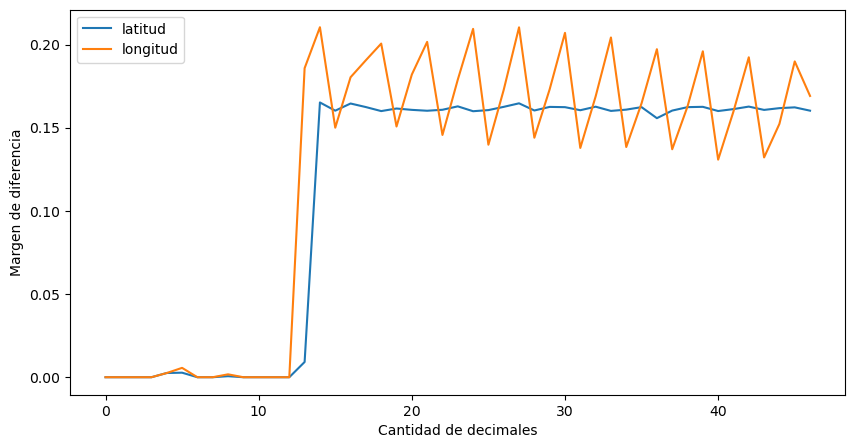

In [74]:
# Lo graficamos
plt.figure(figsize=(10,5))
plt.plot(lat_decimal_diff, label='latitud')
plt.plot(lon_decimal_diff, label='longitud')
plt.ylabel('Margen de diferencia')
plt.xlabel('Cantidad de decimales')
plt.legend()



> Como se puede ver, las diferencias entre lat-lon y lat y lon comienzan a partir de los 13 decimales por lo que podemos descartarla como > una diferencia significativa.
>
> Entonces podemos concluir que la variable lat-lon es redundante y podemos eliminarla.
> ____ 